In [1]:
from typing import List

from oop_functions.experiment_helper import *
from oop_functions.experiment_runner import ExperimentRunner
from oop_functions.util_functions import summarize_features, print_df
from oop_functions.visualization_util import *
from oop_functions.analytics_cv_util import *
from oop_functions.analytics_utils import *

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from xgboost import XGBClassifier

import itertools


In [2]:
def isin_filter(df: pd.DataFrame, col: str, values: List):
    return df[df[col].isin(values)]

In [3]:
label = f'cancer_in_next_1_years'

In [4]:
filesuffix = 'experiment_participants_screened_single_first_5_XGBClassifier_for_cancer_in_next_1_years_15_trials'
cv_analytics_util = CvAnalyticsUtil.load_cv_analytics_utils(filesuffix)

In [5]:
threshold = 0.1611

In [6]:
# TODO: create unique PLCO_ID

In [7]:
id_col = 'index'

In [8]:
all_mid_confidence_ids = []
all_high_confidence_ids = []
all_positive_ids = []
id_and_confidence = []
for analytics_util in cv_analytics_util.analytics_utils:
    y_pred, y_prob = analytics_util.get_predictions() 
    X_test_mismatch = analytics_util.data_util.test_df.copy()[[id_col, 'plco_id', 'age', label]]
    X_test_mismatch[f'{label}_pred'] = y_pred
    X_test_mismatch[f'{label}_prob'] = y_prob
    X_test_mismatch = X_test_mismatch.drop_duplicates()
    # X_test_mismatch = X_test_mismatch[X_test_mismatch[label] != X_test_mismatch[f'{label}_pred']]
    id_and_confidence.append(X_test_mismatch)
mid_conf_predictions = pd.concat(id_and_confidence)
X_test_mismatch = mid_conf_predictions
# Mid confidence
X_test_mid_conf = X_test_mismatch[(X_test_mismatch[f'{label}_prob'] > threshold) & (X_test_mismatch[f'{label}_prob'] < 1 - threshold)]
mid_conf_ids = X_test_mid_conf[id_col].to_list()
all_mid_confidence_ids.extend(mid_conf_ids)
mid_conf_predictions = X_test_mid_conf
# High Conf
X_test_high_conf = X_test_mismatch[(X_test_mismatch[f'{label}_prob'] <= threshold) | (X_test_mismatch[f'{label}_prob'] >= 1 - threshold)]
high_conf_ids = X_test_high_conf[id_col].to_list()
all_high_confidence_ids.extend(high_conf_ids)
# Positive Ids
X_test_positive = X_test_mismatch[(X_test_mismatch[f'{label}_prob'] > 0.5)]
positive_ids = X_test_positive[id_col].to_list()
all_positive_ids.extend(positive_ids)

In [9]:
mid_range_filter = lambda df: isin_filter(df, id_col, all_mid_confidence_ids)
high_range_filter = lambda df: isin_filter(df, id_col, all_high_confidence_ids)
positive_range_filter = lambda df: isin_filter(df, id_col, all_positive_ids)

In [10]:
def set_filter_display_report(cv_analytics_util, filter):
    cv_analytics_util.set_filter(filter)
    cv_analytics_util.get_cv_report();
    cv_analytics_util.display_graph()

In [11]:
# cv_analytics_util.update_thresholds(threshold)



Cross-Validation measures:
+--------------------+----------+-------------+-----------+----------+
|                    |     mean |         std |       min |      max |
|--------------------+----------+-------------+-----------+----------|
| precision__class_0 | 0.999663 | 0.000126079 | 0.999467  | 0.999823 |
| recall__class_0    | 0.996993 | 0.000786017 | 0.99548   | 0.997871 |
| f1-score__class_0  | 0.998326 | 0.000420209 | 0.997558  | 0.998846 |
| precision__class_1 | 0.129045 | 0.0546217   | 0.0576923 | 0.225806 |
| recall__class_1    | 0.552778 | 0.172133    | 0.25      | 0.777778 |
| f1-score__class_1  | 0.20799  | 0.0832824   | 0.1       | 0.35     |
| accuracy           | 0.996659 | 0.000837308 | 0.995129  | 0.997695 |
| auc                | 0.943784 | 0.0440374   | 0.865928  | 0.998103 |
+--------------------+----------+-------------+-----------+----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


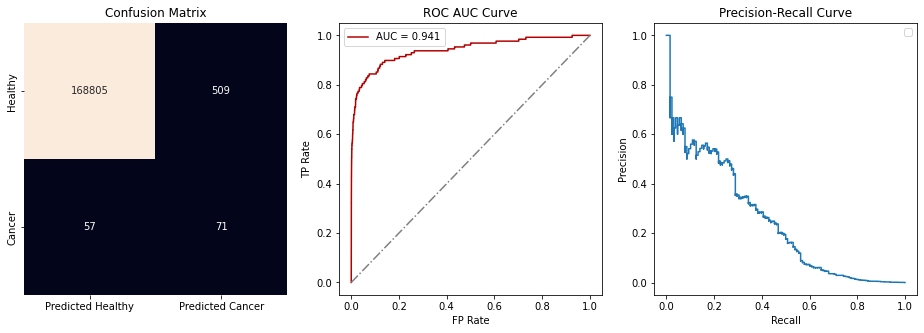



Cross-Validation measures:
+--------------------+-----------+-----------+----------+----------+
|                    |      mean |       std |      min |      max |
|--------------------+-----------+-----------+----------+----------|
| precision__class_0 | 0.986786  | 0.0174049 | 0.952381 | 1        |
| recall__class_0    | 0.741185  | 0.0655116 | 0.626506 | 0.8625   |
| f1-score__class_0  | 0.844936  | 0.0436199 | 0.77037  | 0.926174 |
| precision__class_1 | 0.053939  | 0.035444  | 0        | 0.105263 |
| recall__class_1    | 0.575758  | 0.382707  | 0        | 1        |
| f1-score__class_1  | 0.0973139 | 0.0624899 | 0        | 0.190476 |
| accuracy           | 0.735991  | 0.0659909 | 0.626506 | 0.864198 |
| auc                | 0.639793  | 0.239552  | 0.245614 | 0.971264 |
+--------------------+-----------+-----------+----------+----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


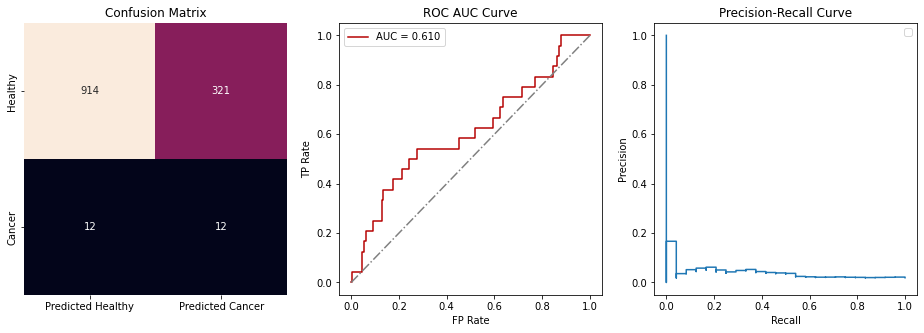



Cross-Validation measures:
+--------------------+----------+-------------+----------+----------+
|                    |     mean |         std |      min |      max |
|--------------------+----------+-------------+----------+----------|
| precision__class_0 | 0.999732 | 0.000112016 | 0.99955  | 1        |
| recall__class_0    | 0.998881 | 0.000344078 | 0.998383 | 0.999464 |
| f1-score__class_0  | 0.999307 | 0.000206782 | 0.998966 | 0.999598 |
| precision__class_1 | 0.249334 | 0.10449     | 0.111111 | 0.5      |
| recall__class_1    | 0.572513 | 0.176995    | 0.375    | 1        |
| f1-score__class_1  | 0.342177 | 0.119551    | 0.173913 | 0.571429 |
| accuracy           | 0.998615 | 0.000412892 | 0.997936 | 0.999197 |
| auc                | 0.935575 | 0.0552326   | 0.806009 | 0.999575 |
+--------------------+----------+-------------+----------+----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


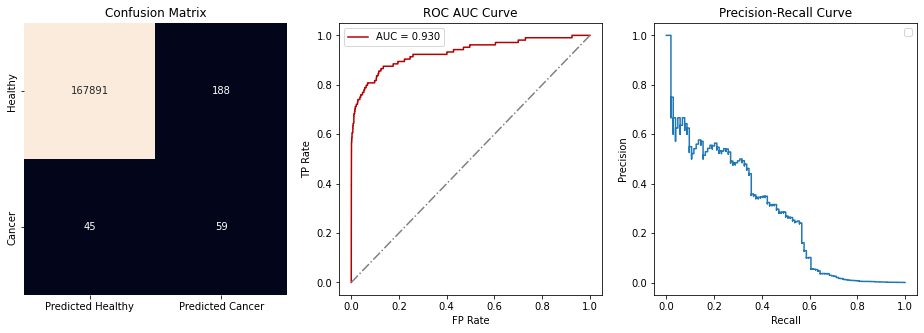

In [12]:
set_filter_display_report(cv_analytics_util, None)
set_filter_display_report(cv_analytics_util, mid_range_filter)
set_filter_display_report(cv_analytics_util, high_range_filter)
# set_filter_display_report(cv_analytics_util, positive_range_filter)

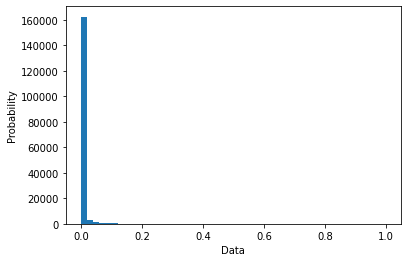

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(X_test_mismatch[f'{label}_prob'], density=False, bins=50)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

